# Daily Barbecue Sauce Sales predcition with xgb

Here in this we build and evaluate the model for the datset, we work with the target value (`amount`). 

We perform
- Clean and transform the raw data
- Engineer features using lags, rolling, calender
- Tune an model using time series cross validation
- Use early stopping with a dedicated validation window
- Evaluate the model
- Perform a walk forward baktest to see how stable performance is over time
- Inspect feature importance to understand what is best for model

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb

df = pd.read_csv("barbecue_sauce_sales.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df["year"]      = df["date"].dt.year
df["month"]     = df["date"].dt.month
df["day"]       = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df["amount"] = df["amount"].interpolate(method="linear")

q1, q3 = df["amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df["amount"] = df["amount"].clip(lower, upper)

for lag in [1, 7, 30]:
    df[f"lag_{lag}"] = df["amount"].shift(lag)

for x in [7, 30]:
    df[f"rolling_mean_{x}"] = df["amount"].shift(1).rolling(x).mean()
    df[f"rolling_std_{x}"]  = df["amount"].shift(1).rolling(x).std()

df["amount_log"] = np.log1p(df["amount"])
df = df.dropna().reset_index(drop=True)
df.head()


,date,amount,year,month,day,dayofweek,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,amount_log
0,2020-02-14,617.0,2020,2,14,4,0,370.0,290.0,285.0,451.928571,396.825993,388.783333,332.714066,6.426488
1,2020-02-17,262.0,2020,2,17,0,0,617.0,1252.5,627.0,498.642857,393.822582,399.850000,334.658785,5.572154
2,2020-02-18,16.0,2020,2,18,1,0,262.0,100.0,241.0,357.142857,215.298575,387.683333,332.745281,2.833213
3,2020-02-19,141.0,2020,2,19,2,0,16.0,640.0,356.0,345.142857,233.583981,380.183333,338.648849,4.955827
4,2020-02-20,200.0,2020,2,20,3,0,141.0,124.0,877.0,273.857143,202.702926,373.016667,341.441732,5.303305


### EDA
We get the features and avoid outliers using the iqr and create lag androlling with mean and standard deviation.As the amount has strong spike, i have interpolated those missing values and usd the iqr to clip those extreme outliers. additional point is that i ahve used log to stablise the amount. 

Next step is that we define which features to use and target for th model. and  define the data to be used for training, validation and testing . here i have used the 80% of the data to train, and 15%of train for validation adn the rest for testing. 

In [29]:
FEATURES = [
    "rolling_mean_30",
    "rolling_std_30",
    "rolling_mean_7",
    "rolling_std_7",
    "dayofweek",
    "month",
    "day",
]
TARGET = "amount_log"

q80 = df["date"].quantile(0.8)

train_df = df[df["date"] <= q80].copy()
test_df  = df[df["date"] >  q80].copy()

X_train_full = train_df[FEATURES]
y_train_full = train_df[TARGET]
X_test = test_df[FEATURES]
y_test = test_df[TARGET]
print("Train size:", len(train_df), "Test size:", len(test_df))


Train size: 1085 Test size: 271


Here i have used the following hyperparameters for trtaining: trees, depth, lr, subsmapling. 
i have used many but randomizedsearchcv worked outmost, so as you can see i have taken 40 rnd combos.

In [30]:
tscv = TimeSeriesSplit(n_splits=4)

base_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

param_dist = {
    "n_estimators": np.arange(300, 1200, 150),
    "learning_rate": [0.1, 0.05, 0.03, 0.01],
    "max_depth": [3, 4, 6, 8],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

rand_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist,
    scoring="neg_mean_absolute_error", 
    cv=tscv,
    n_iter=40,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train_full, y_train_full)

brp = rand_search.best_params_
print("best params:\n", brp)
best_cv_mae = -rand_search.best_score_
print(f"best cv mae: {best_cv_mae:.2f}")


Fitting 4 folds for each of 40 candidates, totalling 160 fits
best params:
 {'subsample': 1.0, 'n_estimators': np.int64(300), 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
best cv mae: 1.49


In [31]:
val_frac = 0.15 
val_size = int(len(train_df) * val_frac)

val_df      = train_df.iloc[-val_size:].copy()
train2_df   = train_df.iloc[:-val_size].copy()
X_train= train2_df[FEATURES]
y_train= train2_df[TARGET]
X_val= val_df[FEATURES]
y_val = val_df[TARGET]
print("train:", len(train2_df), "Validation:", len(val_df))

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)
params_es = {
    "objective": "reg:squarederror",
    "learning_rate": brp["learning_rate"],
    "max_depth": brp["max_depth"],
    "subsample": brp["subsample"],
    "colsample_bytree": brp["colsample_bytree"],
    "min_child_weight": brp["min_child_weight"],
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42
}

max_rounds = int(brp["n_estimators"]) * 3  

evals = [(dtrain, "train"), (dval, "val")]

model_es = xgb.train(
    params=params_es,
    dtrain=dtrain,
    num_boost_round=max_rounds,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Best iteration (early stopping):", model_es.best_iteration)
print("Best validation RMSE:", model_es.best_score)


train: 923 Validation: 162
Best iteration (early stopping): 207
Best validation RMSE: 2.0265275061436907


to reduce the overfitting we use validation here, and we used the dmatrix from teh xgb module which is the data structure used by the xgb model, here we get the best number of trees requored


test performance
rmse: 529.40
mae : 334.18


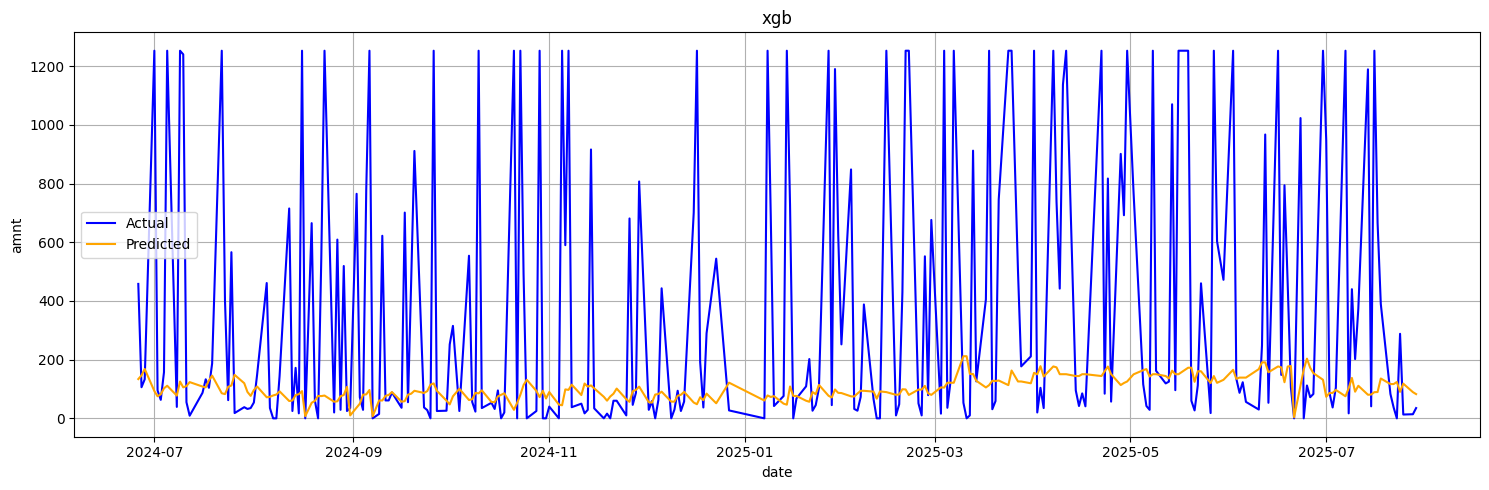

In [32]:
y_pred_log = model_es.predict(
    dtest,
    iteration_range=(0, model_es.best_iteration + 1)
)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print("\ntest performance")
print(f"rmse: {rmse:.2f}")
print(f"mae : {mae:.2f}")

plot_df = test_df.copy()
plot_df["actual"] = y_true
plot_df["pred"]   = y_pred

plt.figure(figsize=(15,5))
plt.plot(plot_df["date"], plot_df["actual"], label="Actual", color="blue")
plt.plot(plot_df["date"], plot_df["pred"],   label="Predicted", color="orange")
plt.title("xgb")
plt.xlabel("date")
plt.ylabel("amnt")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


this is the prediction on the test set on unseen data

This is forward back testing, and in simpole words, it trains an extend of data adn evaluates the next few data dn in inext iter 
here we have used walk forward, this means that it is a bt method which uses rolling or expanding the windows, it checks the model stabitly. This is only for evaltuation not forecasting. 


wf metrics:
   start        rmse         mae
0    651  363.961729  187.412357
1    681  426.648738  228.829790
2    711  338.373161  162.430671
3    741  452.842304  244.931360
4    771  637.235276  438.318943

avg rmse for wf: 490.01700851594495
avg mae for wf: 307.51992116186346
min rmse windows: 282.02
min mae windws: 150.62


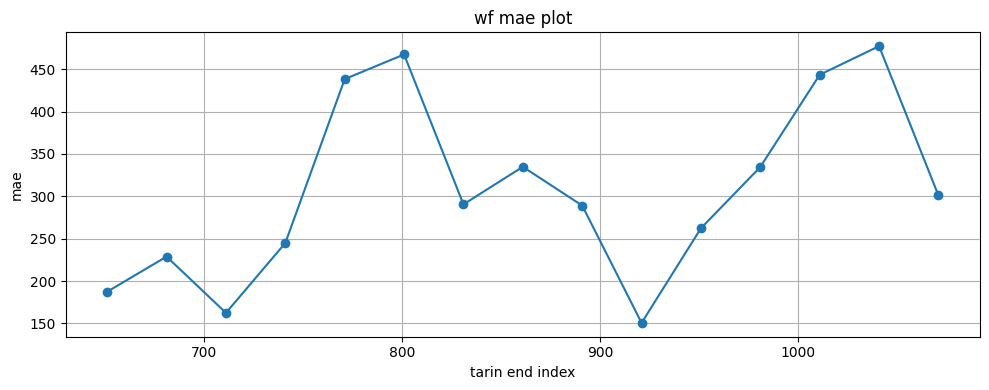

In [33]:
def rbt(params, df_all, features, target,
                        initial_fraction=0.6, step_days=30,
                        val_fraction=0.15):
    df_all = df_all.sort_values("date").reset_index(drop=True)
    n_total = len(df_all)
    n_initial = int(n_total * initial_fraction)

    metrics = []
    preds_list = []
    start = n_initial

    while start < n_total:
        end = min(start + step_days, n_total)

        train_slice = df_all.iloc[:start]
        test_slice  = df_all.iloc[start:end]
        n_tr = len(train_slice)
        n_val = max(1, int(n_tr * val_fraction))
        val_slice   = train_slice.iloc[-n_val:]
        train_inner = train_slice.iloc[:-n_val]

        X_tr = train_inner[features]
        y_tr = train_inner[target]
        X_val = val_slice[features]
        y_val = val_slice[target]
        X_te = test_slice[features]
        y_te = test_slice[target]

        dtr  = xgb.DMatrix(X_tr,  label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dte  = xgb.DMatrix(X_te,  label=y_te)

        booster = xgb.train(
            params=params,
            dtrain=dtr,
            num_boost_round=1000,
            evals=[(dtr, "train"), (dval, "val")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        pred_log = booster.predict(dte, iteration_range=(0, booster.best_iteration + 1))
        pred = np.expm1(pred_log)
        true = np.expm1(y_te)

        rmse = np.sqrt(mean_squared_error(true, pred))
        mae  = mean_absolute_error(true, pred)

        metrics.append({"start": start, "rmse": rmse, "mae": mae})

        tmp = test_slice[["date"]].copy()
        tmp["actual"] = true
        tmp["pred"]   = pred
        preds_list.append(tmp)

        start = end

    return pd.DataFrame(metrics), pd.concat(preds_list)


bt_metrics, bt_preds = rbt(
    params=params_es,
    df_all=train_df,
    features=FEATURES,
    target=TARGET,
    initial_fraction=0.6,
    step_days=30,
    val_fraction=0.15
)

print("\nwf metrics:")
print(bt_metrics.head())

print("\navg rmse for wf:", bt_metrics["rmse"].mean())
print("avg mae for wf:", bt_metrics["mae"].mean())
print(f"min rmse windows: {bt_metrics['rmse'].min():.2f}")
print(f"min mae windws: {bt_metrics['mae'].min():.2f}")

plt.figure(figsize=(10,4))
plt.plot(bt_metrics["start"], bt_metrics["mae"], marker="o")
plt.title("wf mae plot")
plt.xlabel("tarin end index")
plt.ylabel("mae")
plt.grid(True)
plt.tight_layout()
plt.show()


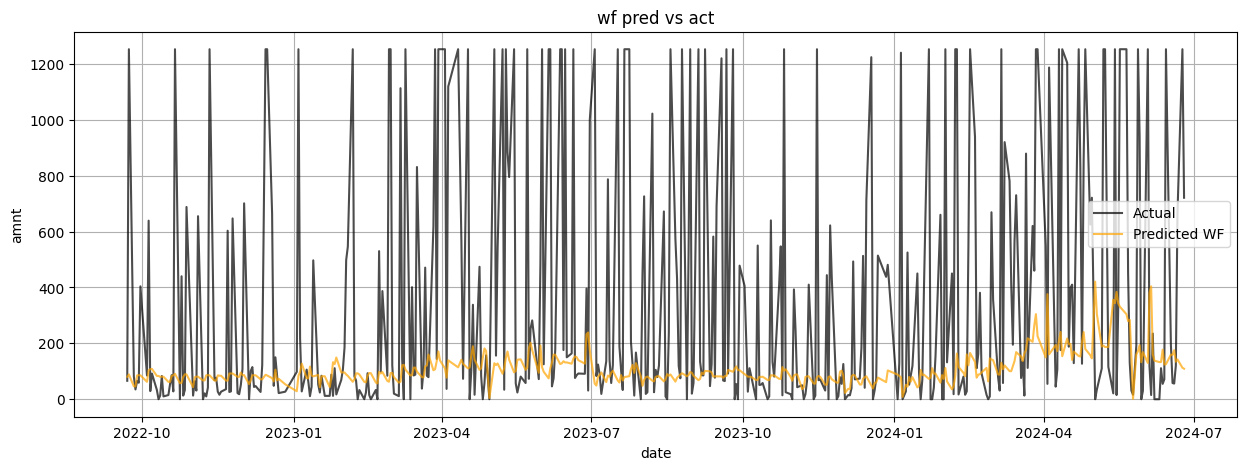

In [34]:
plt.figure(figsize=(15,5))
plt.plot(bt_preds["date"], bt_preds["actual"], label="Actual", color="black", alpha=0.7)
plt.plot(bt_preds["date"], bt_preds["pred"],   label="Predicted WF", color="orange", alpha=0.7)
plt.title("wf pred vs act")
plt.xlabel("date")
plt.ylabel("amnt")
plt.grid(True)
plt.legend()
plt.show()


here the bt_pred is buidlt in the wf loop, this shows what awws trained untli the data upto the prev window vs actual


and how diff is it from tme train test split 

- train test - train on the train df and test on the test df and plot test df with actual vs pred
- wf - train on data upto prev window and test on next window and plot all those windows together
for each 30 day window the model trained on the data avaible until that window and used to forecast the next 30 dats adn these values are concatenated to give the overall pred vs actual plot

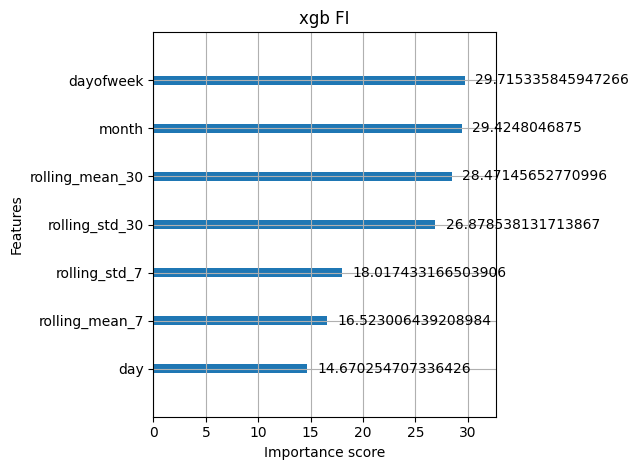


FI
dayofweek          29.715336
month              29.424805
rolling_mean_30    28.471457
rolling_std_30     26.878538
rolling_std_7      18.017433
rolling_mean_7     16.523006
day                14.670255
dtype: float64


In [35]:
xgb.plot_importance(model_es, importance_type="gain")
plt.title("xgb FI")
plt.tight_layout()
plt.show()

importances = model_es.get_score(importance_type="gain")
feat_imp = pd.Series(importances).sort_values(ascending=False)
print("\nFI")
print(feat_imp)
